# Setup

In [1]:
import pdb
import sys

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer

In [2]:
%reload_ext autoreload
%autoreload 2

src_path = "/Users/aarontrefler_temp2/Documents/My Documents/Kaggle/ncaa-men-19/src"
sys.path.insert(0, src_path)

import data
import features as feat

from utils import cols_to_front, display_df

pd.options.display.max_columns = 999

In [3]:
data_raw_dir = '../data/raw/'
data_clean_dir = '../data/clean/'

# Read and Process Data Files

In [4]:
# Read and process teams
df_teams = (
    pd.read_csv(data_raw_dir + 'Stage2DataFiles/Teams.csv')
    .pipe(data.process_teams)
)

# Read and process seeds
df_seeds = (
    pd.read_csv(data_raw_dir + 'Stage2DataFiles/NCAATourneySeeds.csv')
    .pipe(data.process_seeds)
)

# Read and process regular season detailed results
df_rs_d_res = (
    pd.read_csv(data_raw_dir + 'Stage2DataFiles/RegularSeasonDetailedResults.csv')
    .pipe(data.process_regular_season_detailed_results)
    .pipe(feat.create_advanced_statistics)
)

# Read and process tournament games
df_games = (
    pd.read_csv(data_raw_dir + 'Stage2DataFiles/NCAATourneyCompactResults.csv')
    .pipe(data.process_games)
)

# Read and process tournament games submission file
df_sub = (
    pd.read_csv(data_raw_dir + 'SampleSubmissionStage2.csv')
    .pipe(data.process_submission_games)
)

In [5]:
display_df(df_teams, title="Teams")
display_df(df_seeds, title="Seeds")
display_df(df_games, title="Games")
display_df(df_sub, title="Submission Games")
display_df(df_rs_d_res, title="Regular Season Detailed Results")

Teams:


,TeamID,TeamName
0,1101,Abilene Chr


(366, 2)

Seeds:


,Season,Seed,TeamID,IsPlayIn
0,1985,1,1207,False


(2286, 4)

Games:


,Season,Label,TeamOneID,TeamTwoID
0,1985,1,1116,1234


(2184, 4)

Submission Games:


,Season,TeamOneID,TeamTwoID
0,2019,1101,1113


(2278, 3)

Regular Season Detailed Results:


,Ast,Ast_opp,Blk,Blk_opp,DR,DR_opp,DayNum,FGA,FGA3,FGA3_opp,FGA_opp,FGM,FGM3,FGM3_opp,FGM_opp,FTA,FTA_opp,FTM,FTM_opp,Loc,Loc_opp,NumOT,OR,OR_opp,PF,PF_opp,Score,Score_opp,Season,Stl,Stl_opp,TO,TO_opp,TeamID,TeamID_opp,Poss,Poss_opp,OffRating,DefRating,NetRating,Pace
0,13,8,1,2,24,22,10,58,14,10,53,27,3,2,22,18,22,11,16,N,NaN,0,14,10,22,20,68,62,2003,7,9,23,18,1104,1328,75.55,71.45,90.006618,86.773968,3.23265,73.5


(175008, 41)

# Aggregate Data

In [6]:
df_rs_d_res_agg = (
    df_rs_d_res
    .groupby(['TeamID', 'Season'])
    .mean()
    .drop(['TeamID_opp', 'DayNum'], axis=1)
    .reset_index()
)

In [7]:
display_df(df_rs_d_res_agg, tail=True, title="Average Regular Season Detailed Results")

Average Regular Season Detailed Results:


,TeamID,Season,Ast,Ast_opp,Blk,Blk_opp,DR,DR_opp,FGA,FGA3,FGA3_opp,FGA_opp,FGM,FGM3,FGM3_opp,FGM_opp,FTA,FTA_opp,FTM,FTM_opp,NumOT,OR,OR_opp,PF,PF_opp,Score,Score_opp,Stl,Stl_opp,TO,TO_opp,Poss,Poss_opp,OffRating,DefRating,NetRating,Pace
0,1101,2014,10.0,15.571429,1.47619,5.0,20.333333,24.095238,50.142857,17.857143,16.190476,53.428571,20.333333,6.666667,6.0,27.142857,21.190476,25.809524,15.809524,18.333333,0.142857,8.0,10.380952,21.571429,18.666667,63.142857,78.619048,5.761905,7.0,15.0,12.142857,67.208333,67.45,93.486373,116.657445,-23.171072,67.329167


,TeamID,Season,Ast,Ast_opp,Blk,Blk_opp,DR,DR_opp,FGA,FGA3,FGA3_opp,FGA_opp,FGM,FGM3,FGM3_opp,FGM_opp,FTA,FTA_opp,FTM,FTM_opp,NumOT,OR,OR_opp,PF,PF_opp,Score,Score_opp,Stl,Stl_opp,TO,TO_opp,Poss,Poss_opp,OffRating,DefRating,NetRating,Pace
5833,1466,2019,10.172414,13.793103,2.137931,4.758621,25.103448,28.896552,59.655172,24.344828,20.931034,56.517241,22.931034,7.241379,7.344828,26.068966,18.37931,21.482759,12.517241,15.448276,0.0,10.862069,8.413793,18.965517,16.172414,65.62069,74.931034,6.275862,6.517241,13.655172,12.172414,71.178448,70.480172,92.076359,106.003867,-13.927508,70.82931


(5834, 37)

# Merge Datasets

In [8]:
# Merge tournament games with datasets
df_interim_mdl = (
    df_games
    .pipe(data.merge_seed_dataset, df_seeds=df_seeds, submission_file=False)
    .pipe(data.merge_aggregated_regular_season_detailed_results, df_rs_d_res_agg=df_rs_d_res_agg)
    .sort_values(['Season', 'TeamOneID'])
)

# Merge submission file games with datasets
df_interim_sub = (
    df_sub
    .pipe(data.merge_seed_dataset, df_seeds=df_seeds, submission_file=True)
    .pipe(data.merge_aggregated_regular_season_detailed_results, df_rs_d_res_agg=df_rs_d_res_agg)
    .sort_values(['Season', 'TeamOneID'])
)

In [9]:
display_df(df_interim_mdl.sort_values(['Season', 'TeamOneID']), tail=True)
display_df(df_interim_sub, tail=True)

,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace
37,1985,1,1104,1112,7,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace
2132,2018,1,1437,1452,1,5,16.676471,14.0,3.970588,2.676471,26.205882,23.147059,61.529412,28.676471,21.352941,60.205882,31.029412,11.411765,7.0,26.147059,17.617647,15.382353,13.588235,11.588235,0.088235,9.382353,9.558824,15.852941,17.235294,87.058824,70.882353,6.676471,4.558824,10.352941,13.117647,70.868382,71.071324,122.9814,99.758537,23.222863,70.969853,15.058824,12.235294,5.264706,3.941176,23.882353,24.235294,64.0,24.911765,20.147059,52.970588,27.764706,8.794118,7.529412,22.5,19.970588,23.382353,15.294118,16.470588,0.029412,14.0,10.235294,21.382353,18.764706,79.617647,69.0,8.029412,5.470588,11.323529,16.5,70.809559,70.341912,112.591216,98.798682,13.792534,70.575735


(2142, 76)

,Season,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace
0,2019,1101,1113,15,11,14.62069,11.103448,2.551724,2.965517,22.896552,23.758621,55.241379,18.896552,17.103448,51.137931,25.344828,7.241379,5.724138,22.482759,19.068966,19.655172,13.793103,14.206897,0.0,9.068966,8.827586,19.137931,18.068966,71.724138,64.896552,8.0,5.551724,11.655172,15.724138,66.885345,67.37069,107.474884,96.41641,11.058474,67.128017,13.59375,13.28125,3.21875,3.46875,27.8125,25.21875,59.46875,21.25,25.5,58.6875,26.59375,7.25,8.5625,24.21875,25.90625,22.65625,17.375,16.0625,0.03125,12.15625,10.0,19.90625,21.65625,77.8125,73.0625,6.21875,6.34375,13.59375,13.90625,73.211719,73.355469,106.521506,99.660084,6.861422,73.283594


,Season,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace
2277,2019,1459,1463,7,14,14.7,11.633333,2.933333,2.566667,24.433333,21.6,60.1,26.133333,22.1,54.966667,29.3,10.866667,7.233333,23.966667,16.633333,17.5,11.733333,12.366667,0.0,10.3,7.966667,17.5,15.7,81.2,67.533333,6.133333,5.6,11.233333,13.266667,68.934167,68.579167,117.576692,98.064257,19.512435,68.756667,17.0,12.678571,4.321429,2.964286,29.821429,24.357143,60.107143,20.821429,24.071429,63.035714,29.821429,7.785714,7.5,26.0,18.357143,19.285714,13.464286,14.214286,0.0,8.678571,9.607143,17.0,17.142857,80.892857,73.714286,5.75,7.107143,13.25,11.214286,73.398214,73.803571,110.407243,99.723764,10.683479,73.600893


(2278, 75)

# Analyze Missing Data

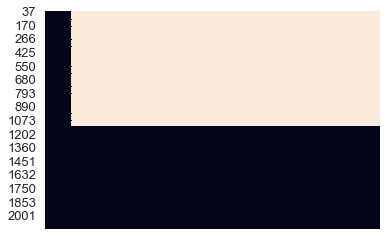

Regular season data available from 2003 onward


In [10]:
sns.heatmap(df_interim_mdl.isnull(), cbar=False, xticklabels=False)
plt.show()
print("Regular season data available from 2003 onward")

# Create Features

In [11]:
def impute_missing_values(df, imputer):
    return pd.DataFrame(imputer.fit_transform(df.values), columns=df.columns)


# Create features for modeling dataset
df_clean_mdl = (
    df_interim_mdl
    .pipe(feat.create_diff_feats)
    .pipe(impute_missing_values, imputer=SimpleImputer(missing_values=np.nan, strategy='median'))
)

# Create features for submission dataset
df_clean_sub = (
    df_interim_sub
    .pipe(feat.create_diff_feats)
    .pipe(impute_missing_values, imputer=SimpleImputer(missing_values=np.nan, strategy='median'))  # no missing data, performed for float conversion consistencty
)

In [12]:
display_df(df_clean_mdl, n=1, tail=True, title="Games")
display_df(df_clean_sub, n=1, title="Submission Games")

Games:


,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
0,1985.0,1.0,1104.0,1112.0,7.0,10.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,-3.0,0.0,0.490111,0.153702,0.050672,0.344328


,Season,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
2141,2018.0,1.0,1437.0,1452.0,1.0,5.0,16.676471,14.0,3.970588,2.676471,26.205882,23.147059,61.529412,28.676471,21.352941,60.205882,31.029412,11.411765,7.0,26.147059,17.617647,15.382353,13.588235,11.588235,0.088235,9.382353,9.558824,15.852941,17.235294,87.058824,70.882353,6.676471,4.558824,10.352941,13.117647,70.868382,71.071324,122.9814,99.758537,23.222863,70.969853,15.058824,12.235294,5.264706,3.941176,23.882353,24.235294,64.0,24.911765,20.147059,52.970588,27.764706,8.794118,7.529412,22.5,19.970588,23.382353,15.294118,16.470588,0.029412,14.0,10.235294,21.382353,18.764706,79.617647,69.0,8.029412,5.470588,11.323529,16.5,70.809559,70.341912,112.591216,98.798682,13.792534,70.575735,1.617647,1.764706,-1.294118,-1.264706,2.323529,-1.088235,-2.470588,7.235294,3.764706,1.205882,3.264706,3.647059,2.617647,-0.529412,-2.352941,-8.0,-1.705882,-4.882353,-4.617647,-0.676471,-5.529412,-1.529412,7.441176,1.882353,-1.352941,-0.911765,-0.970588,-3.382353,0.058824,0.729412,-4.0,0.058824,10.390184,0.959855,9.430329,0.394118


(2142, 112)

Submission Games:


,Season,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
0,2019.0,1101.0,1113.0,15.0,11.0,14.62069,11.103448,2.551724,2.965517,22.896552,23.758621,55.241379,18.896552,17.103448,51.137931,25.344828,7.241379,5.724138,22.482759,19.068966,19.655172,13.793103,14.206897,0.0,9.068966,8.827586,19.137931,18.068966,71.724138,64.896552,8.0,5.551724,11.655172,15.724138,66.885345,67.37069,107.474884,96.41641,11.058474,67.128017,13.59375,13.28125,3.21875,3.46875,27.8125,25.21875,59.46875,21.25,25.5,58.6875,26.59375,7.25,8.5625,24.21875,25.90625,22.65625,17.375,16.0625,0.03125,12.15625,10.0,19.90625,21.65625,77.8125,73.0625,6.21875,6.34375,13.59375,13.90625,73.211719,73.355469,106.521506,99.660084,6.861422,73.283594,1.02694,-2.177802,-0.667026,-0.503233,-4.915948,-1.460129,-4.227371,-7.549569,-2.353448,-8.396552,-1.248922,-1.735991,-0.008621,-2.838362,-6.837284,-3.001078,-3.581897,-1.855603,-3.087284,-1.172414,-0.768319,-3.587284,-6.088362,-8.165948,1.78125,-0.792026,-1.938578,1.817888,-6.326374,-5.984779,4.0,-0.03125,0.953377,-3.243674,4.197052,-6.155577


(2278, 111)

# Save datasets

In [13]:
df_clean_mdl_save = (
    df_clean_mdl
    .pipe(data.merge_team_dataset, df_teams=df_teams)
    .sort_values(['Season', 'TeamOneID'])
    .pipe(cols_to_front, front_cols=['Season', 'TeamOne_Name', 'TeamTwo_Name'])
)

df_clean_sub_save = (
    df_clean_sub
    .pipe(data.merge_team_dataset, df_teams=df_teams)
    .sort_values(['Season', 'TeamOneID'])
    .pipe(cols_to_front, front_cols=['Season', 'TeamOne_Name', 'TeamTwo_Name'])
)

In [14]:
display_df(df_clean_mdl_save, n=5, tail=True, title="Past Games")
display_df(df_clean_sub_save, n=5, tail=True, title="2019 Games")

Past Games:


,Season,TeamOne_Name,TeamTwo_Name,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
0,1985.0,Alabama,Arizona,1.0,1104,1112,7.0,10.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,-3.0,0.0,0.490111,0.153702,0.050672,0.344328
2,1985.0,Alabama,VA Commonwealth,1.0,1104,1433,7.0,2.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,18.758098,18.587198,55.8125,25.969697,6.8,6.107143,22.891176,21.368519,18.5,15.149287,12.666667,0.057143,11.735294,10.909091,17.550056,19.16129,73.809091,65.129032,6.882353,6.014706,12.545455,13.88057,67.701591,67.659652,109.385849,95.974371,13.78543,67.667773,0.148522,0.006061,0.102083,0.017793,0.142525,-0.092708,0.210446,0.621473,-0.124777,-0.065236,0.364468,0.298574,0.061581,0.001927,0.319073,0.036706,0.266544,-0.010959,-0.018939,0.266043,0.109927,0.053883,0.959197,0.494656,0.097232,0.134241,0.192761,0.03457,0.406157,0.417045,5.0,0.0,0.490111,0.153702,0.050672,0.344328
21,1985.0,Alabama,NC State,0.0,1104,1301,7.0,3.0,14.774194,11.939394,4.0,3.135632,24.8,21.863971,56.716578,18.741935,18.727273,56.298574,26.412121,6.864368,6.151515,23.096774,21.571429,18.439338,15.298574,12.612903,0.058824,11.65625,11.112395,17.636364,19.063508,74.911765,65.272727,6.9375,5.970588,12.777722,13.875,67.914504,67.954839,110.166058,96.550243,13.424874,67.951788,14.537054,11.934409,3.823529,3.137931,24.790998,22.140394,56.867965,1

,Season,TeamOne_Name,TeamTwo_Name,Label,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
2108,2018.0,Tennessee,Wright St,1.0,1397,1460,3.0,14.0,15.818182,10.818182,4.484848,3.303030,24.484848,23.090909,57.484848,20.454545,19.939394,54.939394,25.242424,7.848485,6.363636,22.515152,21.000000,21.060606,15.878788,15.000000,0.060606,11.666667,11.242424,19.575758,19.515152,74.212121,66.393939,6.303030,5.636364,12.212121,13.939394,68.005303,67.640152,109.414278,98.163525,11.250753,67.822727,13.218750,11.843750,2.281250,2.906250,26.093750,25.093750,57.531250,20.125000,22.281250,56.093750,24.781250,6.843750,7.781250,23.187500,20.718750,16.812500,14.906250,12.000000,0.062500,10.125000,8.687500,16.031250,20.031250,71.312500,66.156250,6.593750,5.906250,13.062500,14.843750,70.310156,70.235938,101.332394,94.131659,7.200736,70.273047,2.599432,-1.025568,2.203598,0.396780,-1.608902,-2.002841,-0.046402,-1.154356,0.329545,-2.341856,0.461174,-0.672348,1.004735,-1.417614,0.281250,4.248106,0.972538,3.000000,1.541667,2.554924,3.544508,-0.516098,2.899621,0.237689,-0.290720,-0.269886,-0.850379,-0.904356,-2.304853,-2.595786,-11.0,-0.001894,8.081884,4.031867,4.050017,-2.450320
644,2018.0,Texas Tech,Villanova,0.0,1403,1437,3.0,1.0,14.424242,10.363636,4.272727,3.636364,24.939394,21.939394,56.363636,19.212121,20.969697,54.030303,26.151515,7.030303,6.878788,21.757576,22.696970,20.545455,15.909091,14.303030,0.060606,11.000000,9.818182,18.151515,20.878788,75.242424,64.696970,7.393939,5.939394,12.545455,15.181818,68.690152,69.153030,109.643838,93.850766,15.793072,68.921591,16.676471,14.000000,3.970588,2.676471,26.205882,23.147059,61.529412,28.676471,21.352941,60.205882,31.029412,11.411765,7.000000,26.147059,17.617647,15.382353,13.588235,11.588235,0.088235,9.382353,9.558824,15.852941,17.235294,87.058824,70.882353,6.676471,4.558824,10.352941,13.117647,70.868382,71.071324,122.981400,99.758537,23.222863,70.969853,-2.252228,-3.636364,0.302139,0.959893,-1.266488,-1.207665,-5.165775,-6.175579,-9.464349,-0.383244,-4.877897,-4.389483,-4.381462,-0.121212,5.079323,5.163102,2.320856,2.714795,1.617647,0.259358,2.298574,3.643494,-11.816399,-6.185383,0.717469,1.380570,2.192513,2.064171,-2.178231,-1.918293,2.0,-0.027629,-13.337562,-5.907771,-7.429791,-2.048262
92,2018.0,TX Southern,Xavier,0.0,1411,1462,16.0,1.0,12.264706,15.882353,3.941176,3.911765,25.882353,25.794118,58.500000,21.529412,21.352941,64.323529,25.823529,7.823529,7.911765,29.176471,25.294118,20.176471,18.176471,13.470588,0.058824,10.294118,12.264706,17.735294,21.088235,77.647059,79.735294,5.588235,5.294118,12.617647,11.676471,72.8

(2142, 114)

2019 Games:


,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
0,2019.0,Abilene Chr,Arizona St,1101,1113,15.0,11.0,14.62069,11.103448,2.551724,2.965517,22.896552,23.758621,55.241379,18.896552,17.103448,51.137931,25.344828,7.241379,5.724138,22.482759,19.068966,19.655172,13.793103,14.206897,0.0,9.068966,8.827586,19.137931,18.068966,71.724138,64.896552,8.0,5.551724,11.655172,15.724138,66.885345,67.37069,107.474884,96.41641,11.058474,67.128017,13.593750,13.281250,3.218750,3.468750,27.812500,25.218750,59.468750,21.250000,25.500000,58.687500,26.593750,7.250000,8.562500,24.218750,25.906250,22.656250,17.375000,16.062500,0.03125,12.156250,10.000000,19.906250,21.656250,77.812500,73.062500,6.218750,6.343750,13.593750,13.906250,73.211719,73.355469,106.521506,99.660084,6.861422,73.283594,1.026940,-2.177802,-0.667026,-0.503233,-4.915948,-1.460129,-4.227371,-7.549569,-2.353448,-8.396552,-1.248922,-1.735991,-0.008621,-2.838362,-6.837284,-3.001078,-3.581897,-1.855603,-3.087284,-1.172414,-0.768319,-3.587284,-6.088362,-8.165948,1.781250,-0.792026,-1.938578,1.817888,-6.326374,-5.984779,4.0,-0.03125,0.953377,-3.243674,4.197052,-6.155577
1,2019.0,Abilene Chr,Auburn,1101,1120,15.0,5.0,14.62069,11.103448,2.551724,2.965517,22.896552,23.758621,55.241379,18.896552,17.103448,51.137931,25.344828,7.241379,5.724138,22.482759,19.068966,19.655172,13.793103,14.206897,0.0,9.068966,8.827586,19.137931,18.068966,71.724138,64.896552,8.0,5.551724,11.655172,15.724138,66.885345,67.37069,107.474884,96.41641,11.058474,67.128017,14.411765,12.029412,4.764706,3.676471,21.941176,24.176471,60.441176,29.970588,23.382353,52.941176,27.029412,11.411765,8.323529,23.235294,18.735294,19.352941,13.411765,13.794118,0.00000,11.735294,10.764706,18.382353,17.205882,78.882353,68.588235,9.294118,5.911765,12.147059,17.588235,69.752206,68.957353,113.004517,99.688575,13.315942,69.354779,0.208925,-0.925963,-2.212982,-0.710953,0.955375,-0.417850,-5.199797,-1.803245,-11.074037,-6.278905,-1.684584,-0.752535,-4.170385,-2.599391,0.333671,0.302231,0.381339,0.412779,-2.666329,-1.937120,0.755578,0.863083,-7.158215,-3.691684,-1.294118,-0.360041,-0.491886,-1.864097,-2.866861,-1.586663,10.0,0.00000,-5.529633,-3.272165,-2.257469,-2.226762
3,2019.0,Abilene Chr,Baylor,1101,1124,15.0,9.0,14.62069,11.103448,2.551724,2.965517,22.896552,23.758621,55.241379,18.896552,17.103448,51.137931,25.344828,7.241379,5.724138,22.482759,19.068966,19.655172,13.793103,14.206897,0.0,9.068966,8.827586,19.137931,18.068966,71.724138,64.896552,8.0,5.551724,11.655172,15.724138,66.885345,67.37069,107.474884,96.41641,11.058474,67.

,Season,TeamOne_Name,TeamTwo_Name,TeamOneID,TeamTwoID,TeamOne_Seed,TeamTwo_Seed,TeamOne_Ast,TeamOne_Ast_opp,TeamOne_Blk,TeamOne_Blk_opp,TeamOne_DR,TeamOne_DR_opp,TeamOne_FGA,TeamOne_FGA3,TeamOne_FGA3_opp,TeamOne_FGA_opp,TeamOne_FGM,TeamOne_FGM3,TeamOne_FGM3_opp,TeamOne_FGM_opp,TeamOne_FTA,TeamOne_FTA_opp,TeamOne_FTM,TeamOne_FTM_opp,TeamOne_NumOT,TeamOne_OR,TeamOne_OR_opp,TeamOne_PF,TeamOne_PF_opp,TeamOne_Score,TeamOne_Score_opp,TeamOne_Stl,TeamOne_Stl_opp,TeamOne_TO,TeamOne_TO_opp,TeamOne_Poss,TeamOne_Poss_opp,TeamOne_OffRating,TeamOne_DefRating,TeamOne_NetRating,TeamOne_Pace,TeamTwo_Ast,TeamTwo_Ast_opp,TeamTwo_Blk,TeamTwo_Blk_opp,TeamTwo_DR,TeamTwo_DR_opp,TeamTwo_FGA,TeamTwo_FGA3,TeamTwo_FGA3_opp,TeamTwo_FGA_opp,TeamTwo_FGM,TeamTwo_FGM3,TeamTwo_FGM3_opp,TeamTwo_FGM_opp,TeamTwo_FTA,TeamTwo_FTA_opp,TeamTwo_FTM,TeamTwo_FTM_opp,TeamTwo_NumOT,TeamTwo_OR,TeamTwo_OR_opp,TeamTwo_PF,TeamTwo_PF_opp,TeamTwo_Score,TeamTwo_Score_opp,TeamTwo_Stl,TeamTwo_Stl_opp,TeamTwo_TO,TeamTwo_TO_opp,TeamTwo_Poss,TeamTwo_Poss_opp,TeamTwo_OffRating,TeamTwo_DefRating,TeamTwo_NetRating,TeamTwo_Pace,Diff_Ast,Diff_Ast_opp,Diff_Blk,Diff_Blk_opp,Diff_DR,Diff_DR_opp,Diff_FGA,Diff_FGA_opp,Diff_FGA3,Diff_FGA3_opp,Diff_FGM,Diff_FGM_opp,Diff_FGM3,Diff_FGM3_opp,Diff_FTA,Diff_FTA_opp,Diff_FTM,Diff_FTM_opp,Diff_OR,Diff_OR_opp,Diff_PF,Diff_PF_opp,Diff_Score,Diff_Score_opp,Diff_Stl,Diff_Stl_opp,Diff_TO,Diff_TO_opp,Diff_Poss,Diff_Poss_opp,Diff_Seed,Diff_NumOT,Diff_OffRating,Diff_DefRating,Diff_NetRating,Diff_Pace
2209,2019.0,Washington,Wofford,1449,1459,9.0,7.0,11.676471,13.117647,5.735294,2.470588,22.117647,22.529412,54.264706,21.588235,19.117647,54.147059,24.558824,7.470588,6.323529,22.441176,19.058824,18.676471,13.235294,13.176471,0.0,9.470588,11.647059,18.411765,18.411765,69.823529,64.382353,9.000000,6.147059,13.352941,16.235294,67.200000,67.606618,103.903790,95.316150,8.587640,67.403309,14.7,11.633333,2.933333,2.566667,24.433333,21.600000,60.100000,26.133333,22.100000,54.966667,29.300000,10.866667,7.233333,23.966667,16.633333,17.500000,11.733333,12.366667,0.0,10.300000,7.966667,17.5,15.700000,81.200000,67.533333,6.133333,5.600000,11.233333,13.266667,68.934167,68.579167,117.576692,98.064257,19.512435,68.756667,-3.023529,1.484314,2.801961,-0.096078,-2.315686,0.929412,-5.835294,-0.819608,-4.545098,-2.982353,-4.741176,-1.525490,-3.396078,-0.909804,2.425490,1.176471,1.501961,0.809804,-0.829412,3.680392,0.911765,2.711765,-11.376471,-3.150980,2.866667,0.547059,2.119608,2.968627,-1.734167,-0.972549,2.0,0.0,-13.672901,-2.748107,-10.924795,-1.353358
2275,2019.0,Washington,Yale,1449,1463,9.0,14.0,11.676471,13.117647,5.735294,2.470588,22.117647,22.529412,54.264706,21.588235,19.117647,54.147059,24.558824,7.470588,6.323529,22.441176,19.058824,18.676471,13.235294,13.176471,0.0,9.470588,11.647059,18.411765,18.411765,69.823529,64.382353,9.000000,6.147059,13.352941,16.235294,67.200000,67.606618,103.903790,95.316150,8.587640,67.403309,17.0,12.678571,4.321429,2.964286,29.821429,24.357143,60.107143,20.821429,24.071429,63.035714,29.821429,7.785714,7.500000,26.000000,18.357143,19.285714,13.464286,14.214286,0.0,8.678571,9.607143,17.0,17.142857,80.892857,73.714286,5.750000,7.107143,13.250000,11.214286,73.398214,73.803571,110.407243,99.723764,10.683479,73.600893,-5.323529,0.439076,1.413866,-0.493697,-7.703782,-1.827731,-5.842437,-8.888655,0.766807,-4.953782,-5.262605,-3.558824,-0.315126,-1.176471,0.701681,-0.609244,-0.228992,-1.037815,0.792017,2.039916,1.411765,1.268908,-11.069328,-9.331933,3.250000,-0.960084,0.102941,5.021008,-6.198214,-6.196954,-5.0,0.0,-6.503452,-4.407613,-2.095839,-6.197584
2210,2019.0,Wisconsin,Wofford,1458,1459,5.0,7.0,12.757576,10.303030,4.212121,4.030303,27.060606,25.757576,57.121212,19.454545,20.212121,57.545455,25.878788,7.121212,6.303030,22.606061,15.696970,14.909091,10.181818,9.909091,0.0,8.151515,9.757576,15.060606,17.484848,69.060606,61.424242,5.121212,5.151515,9.545455,11.363636,65.971212,66.233333,104.505310,92.729393,11.775917,66.102273,14.7,11.633333,2.9333

(2278, 113)

In [15]:
df_clean_mdl_save.to_csv(data_clean_dir + 'model_dataset.csv', index=False)
df_clean_sub_save.to_csv(data_clean_dir + 'submission_dataset.csv', index=False)